In [4]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint, EvalBinomialPmf, Hist
import thinkplot
import numpy as np
import random

# Battleship Problem
First, I will make a simple class that will update its hypotheses about the ship's location based on whether its shot was a hit or a miss. This is pretty straightforward. For now, we will use the exponential verson of the likelihood function, if I have time, I might circle back and improve that.

In [5]:
class battleship_hunter(Suite, Joint):
    def Likelihood(self, data, hypo):
        """
        data: a tuple containing a tuple and a Boolean, ((where we shot), hit or miss)
        hypo: Location of the ship
        """
        coord_fired, hit = data
        coord_h = hypo
        
        dist = np.linalg.norm(np.array(coord_h) - np.array(coord_fired))
        like_hit =  np.exp(-dist)
        if hit:
            return like_hit 
        else:
            return 1-like_hit

/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


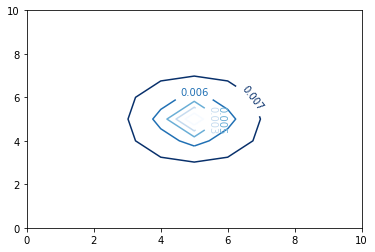

In [6]:
xs = np.linspace(0, 10, 11)
pairs = []
for x in xs:
    for y in xs:
        pairs.append((x, y))
ship = battleship_hunter(pairs)
coord = (5, 5)
data = (coord, False)
ship.Update(data)
thinkplot.Contour(ship)

(0.0, 10.0)


/home/jonah/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


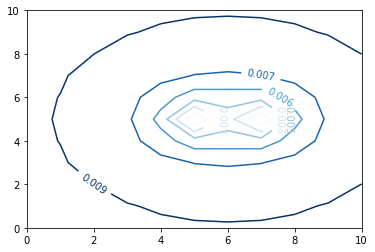

In [7]:
coord = (7, 5)
data = (coord, False)
ship.Update(data)
thinkplot.Contour(ship)

print(ship.MAP())

### The Game
First, I am going to make a class which will act how the problem describes, reporting a hit probabilistically as a function of distance. I will include methods to initialize a random coordinate, to check to see if it should report a hit, and to let us know how we did at the end.

In [8]:
class Battleship():
    def __init__(self, coord=None):
        #Pick a random coordinate unless you provide one
        if coord == None:
            self.coord = (random.randint(0,10), random.randint(0,10))
        else:
            self.coord = coord
    def check_for_hit(self, attack):
        #Decides whether or not it will report a hit
        dist = np.linalg.norm(np.array(self.coord) - np.array(attack))
        p = np.exp(-dist)
        if random.random() < p:
            #If p (or probability of reporting hit) is really big, will usually return a hit
            return True
        else:
            return False
    def spill_secrets(self, verbose=False):
        #To find out at the end how well we did.
        if verbose == True:
            print(self.coord)
        return self.coord

Next comes the hard part. I need some sort of search algorithm. The simplest possible one would just find the MAP of the joint distribution and shoot there. Let's see how many tries it takes that algorithm to get some certainty (say, 90%, for now) that it knows where the ship is.

First, I need to add a method to my battleship hunter class to find its next target. (For now, I could just use the .MAP() method, but soon I will be changing it, so I want to include it so I can reuse functions later)

In [9]:
class MAP_battleship_hunter(battleship_hunter):
    def next_target(self):
        return self.MAP()

Now, a function that wraps up all these methods and continues firing until the hunter thinks it has found the ship.

In [18]:
def play_battleship(ship_type, coord=None, cert_thresh = 0.9, verbose=False):
    
    # Initialize both the ship and the hunter
    hidden_ship = Battleship(coord)
    xs = np.linspace(0, 10, 11)
    pairs = []
    for x in xs:
        for y in xs:
            pairs.append((x, y))
    hunter = ship_type(pairs)
    
    # Begin loop. Until certain enough, keep shooting.
    certainty = 0
    shots = 0
    first_shot = True
    MKIII = False
    if ship_type == MKIII_battleship_hunter:
        MKIII = True
        first_shot = True
    while certainty < cert_thresh:
        if MKIII:
            coord = hunter.next_target(first_shot)
            first_shot = False
        else:
            coord = hunter.next_target()
        hit = hidden_ship.check_for_hit(coord)
        hunter.Update((coord, hit))
        certainty = hunter[hunter.MAP()] # I am sure there is a method for this but I don't know what it is.
        shots += 1
    
    spot = hidden_ship.spill_secrets(verbose)
    if verbose==True:
        print("Best Guess:\n", hunter.MAP())
        print("Actual result:")
        print("Shots require: " + str(shots))
    return shots, hunter.MAP(), spot

In [19]:
a, b, c = play_battleship(MAP_battleship_hunter, verbose=True)
b == c


(0, 2)
Best Guess:
 (0.0, 2.0)
Actual result:
Shots require: 23


True

Great, now we can run that simulation to get an idea of an average. Because this model is deterministic (right now) for each location, I only have to run it once for each pair.

In [20]:
def test_class(ship_type):
    shots = []
    xs = np.linspace(0, 10, 11)
    pairs = []
    for x in xs:
        for y in xs:
            pairs.append((x, y))
    shot_map = {}
    for pair in pairs:
        shot = play_battleship(MAP_battleship_hunter, coord=pair)[0]
        shots.append(shots)
        shot_map[pair] = shot
    print("Lowest:", np.amin(shots))
    print("Highest:", np.amax(shots))
    print("Average:", np.mean(shots))
    print("Standard Deviation:", np.std(shots))
    thinkplot.Hist(Hist(shots))

In [ ]:
test_class(MAP_battleship_hunter)

In [ ]:
shots = []
xs = np.linspace(0, 10, 11)
pairs = []
for x in xs:
    for y in xs:
        pairs.append((x, y))
shot_map = {}
for pair in pairs:
    shot = play_battleship(MAP_battleship_hunter, coord=pair)[0]
    shots.append(shot)
    shot_map[pair] = shot
print("Lowest:", np.amin(shots))
print("Highest:", np.amax(shots))
print("Average:", np.mean(shots))
print("Standard Deviation:", np.std(shots))
thinkplot.Hist(Hist(shots))

I have a feeling we can make this better. First, the easiest thing to do is figure out how certain we have to be before we make our guess. I bet that we can be much less certain than 90%, a much lower MAP over 100 possible hypotheses is still a pretty good indicator that that spot is probably the right one. 

In [115]:
def test_cert(num_tests, certs):
    cert_scores = {}
    for cert in certs:
        total_right = 0
        for i in range(num_tests):
            num_shots, guess, answer = play_battleship_MAP(cert_thresh=cert)
            if guess == answer:
                total_right += 1
        percent_correct = 100 * total_right/num_tests
        cert_scores[cert] = percent_correct
        #print("For cert=%s, guessed %s percent correct" % (cert, percent_correct))
    return cert_scores
            

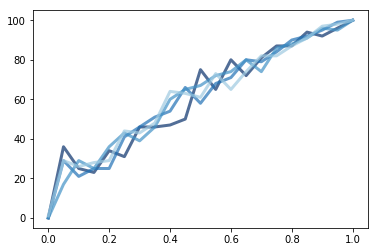

In [116]:
#Lets make a cool plot with a few lines
for i in range(4):
    certs = np.linspace(0, 1, 21)
    scores = test_cert(100, certs)
    thinkplot.plot(Hist(scores))

In [117]:
print(scores)

{0.0: 1.0, 0.05: 29.0, 0.1: 26.0, 0.15000000000000002: 28.0, 0.2: 29.0, 0.25: 44.0, 0.30000000000000004: 43.0, 0.35000000000000003: 48.0, 0.4: 64.0, 0.45: 63.0, 0.5: 61.0, 0.55: 73.0, 0.6000000000000001: 65.0, 0.65: 74.0, 0.7000000000000001: 82.0, 0.75: 82.0, 0.8: 87.0, 0.8500000000000001: 91.0, 0.9: 97.0, 0.9500000000000001: 98.0, 1.0: 100.0}


Interesting, I was pretty wrong about that. It looks like it rises logarithmically, or roughly linearly at higher thresholds. I will stick with a 90% threshold, which should give me a good success rate. Much lower than that and we are seeing 1-2 failures in 10, which is a little too high for the arbitrary standards I just made up. It looks like I will have to actually make a more clever search algorithm.

The first thing to do is try to find a spot with more "empty space" around it. Right now, if multiple points have the same value, it shoots at the one that is furthest up and to the right. This might sometimes provide less information than shooting far from edges (for example, our very first shot is going to shoot in the top right hand corner, which will give us 1/4 as much information as shooting the center).

First, a pretty simple one, this will walktowards the center until the value is lower than at the MAP. This is pretty simple and rough, and it will totally miss sections of equal likelihood across the grid from it's starting point.

In [82]:
class MKII_battleship_hunter(battleship_hunter):
    def next_target(self):
        #Get our current best information
        best = self.MAP()
        best_val = self[best]
        
        #Initialize our "next steps"
        new_best = best
        new_best_val = best_val
        while new_best_val == best_val:
            x, y = new_best
            old_best = new_best # If we are at the top of this loop, then we are good to use these numbers
            if old_best == (5,5):
                break # Need to break if we get to the middle or it does this forever.
            
            # Updates new_best
            if x > 5:
                new_x = x - 1
            elif x < 5:
                new_x = x + 1
            else:
                new_x = x
            
            if y > 5:
                new_y = y - 1
            elif y < 5:
                new_y = y + 1
            else:
                new_y = y
            
            
            new_best = (new_x,new_y)
            new_best_val = self[new_best] # Then, will check to see if it still works.
        
        return old_best

In [83]:
a, b, c = play_battleship(MKII_battleship_hunter, verbose=True)
b == c

(9, 1)
Best Guess:
 (9.0, 1.0)
Actual result:
Shots require: 27


True

Let's see if this is actually better.

In [84]:
shots = []
for i in range(10000):
    shots.append(play_battleship(MKII_battleship_hunter)[0])

In [85]:
print("Lowest:", np.amin(shots))
print("Highest:", np.amax(shots))
print("Average:", np.mean(shots))
print("Standard Deviation:", np.std(shots))

Lowest: 4
Highest: 117
Average: 30.4137
Standard Deviation: 18.87133149276966


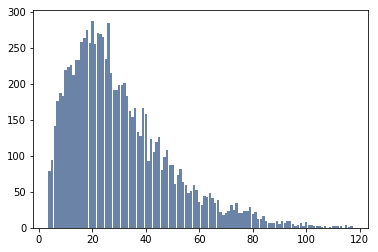

In [86]:
thinkplot.Hist(Hist(shots))

Well, this hasn't worked at all. I guess I should try again.

I am going to make small changes, so the next iteration will just shoot at the center the first time, and then shoot at the MAP after that. This will require a slight change to the play_battleship function.

In [12]:
class MKIII_battleship_hunter(battleship_hunter):
    def next_target(self, first_shot):
        if first_shot:
            return (5,5)
        return self.MAP()

In [88]:
def play_battleship(ship_type, coord=None, cert_thresh = 0.9, verbose=False):
    
    # Initialize both the ship and the hunter
    hidden_ship = Battleship(coord)
    xs = np.linspace(0, 10, 11)
    pairs = []
    for x in xs:
        for y in xs:
            pairs.append((x, y))
    hunter = ship_type(pairs)
    
    # Begin loop. Until certain enough, keep shooting.
    certainty = 0
    shots = 0
    first_shot = True
    if ship_type == MKIII_battleship_hunter:
        first_shot = True
    while certainty < cert_thresh:
        coord = hunter.next_target(first_shot)
        first_shot = False
        hit = hidden_ship.check_for_hit(coord)
        hunter.Update((coord, hit))
        certainty = hunter[hunter.MAP()] # I am sure there is a method for this but I don't know what it is.
        shots += 1
    
    spot = hidden_ship.spill_secrets(verbose)
    if verbose==True:
        print("Best Guess:\n", hunter.MAP())
        print("Actual result:")
        print("Shots require: " + str(shots))
    return shots, hunter.MAP(), spot

In [89]:
a, b, c = play_battleship(MKIII_battleship_hunter, verbose=True)
b == c

(10, 8)
Best Guess:
 (10.0, 8.0)
Actual result:
Shots require: 21


True

Still not significantly better. I might have to actually be clever here.

Unfortunately, at this point I think I am going to have to turn in what I have, hopefully i can return to this in the future as I was enjoying it and I want to come up with something good for it as opposed to hoping a couple minor tweaks will improve performance (and then being disappointed when they don't). Oh well. 